In [1]:
!pip install segmentation-models-pytorch -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.1 MB/s eta 0:00:00:00:0100:01
ERROR: pip's depende

In [25]:
# https://platform.olimpiada-ai.ro/problems/48

import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
import segmentation_models_pytorch as smp
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.io import write_png
import shutil

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

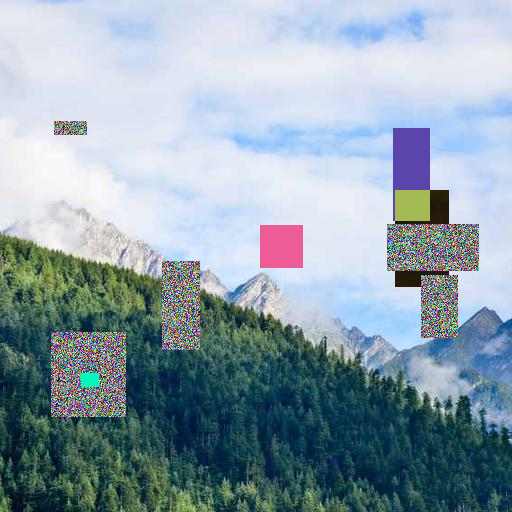

In [4]:
Image.open('/kaggle/input/the-glitch-hunter/train/images/img_005.png')

In [5]:
class GlitchDataset(Dataset):
    def __init__(self, images_dir, masks_dir=None, is_test=False, img_transform=None, mask_transform=None):
        super().__init__()
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.is_test = is_test
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        
    def __len__(self):
        return len(os.listdir(self.images_dir))
        
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.images_dir, f"img_{(idx+1):03d}.png"))
        if self.img_transform is not None:
            img = self.img_transform(img)

        if self.is_test:
            return img
        
        mask = Image.open(os.path.join(self.masks_dir, f"mask_{(idx+1):03d}.png"))
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)

        return img, mask 

transform = transforms.ToTensor()

train_ds = GlitchDataset(
    images_dir='/kaggle/input/the-glitch-hunter/train/images',
    masks_dir='/kaggle/input/the-glitch-hunter/train/masks',
    is_test=False,
    img_transform=transform,
    mask_transform=transform,
)

train_loader = DataLoader(train_ds, shuffle=True, batch_size=8)

In [6]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-3)
loss_fn = nn.BCEWithLogitsLoss()

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [7]:
epochs = 15
log_rate = 1

losses, ious = [], []

for epoch in tqdm(range(epochs), desc='Training the model'):
    model.train()
    train_loss, running_iou, i = 0, 0, 0
    for X_batch, y_batch in (pbar := tqdm(train_loader, desc='Train DataLoader', leave=False)):
        i += 1
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        output = model(X_batch)
        
        loss = loss_fn(output, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        losses.append(train_loss/i)

        tp, fp, fn, tn = smp.metrics.get_stats(output, y_batch.long(), mode='binary', threshold=0.5)
        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        running_iou += iou.item()
        ious.append(running_iou/i)

        pbar.set_postfix({'loss': f'{train_loss/i:.5f}', 'iou': f'{running_iou/i:.5f}'})
    
    if (epoch+1)%log_rate==0:
        print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss/i:.5f} | Train IoU: {running_iou/i:.5f}")

Training the model:   0%|          | 0/15 [00:00<?, ?it/s]

Train DataLoader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1/15 | Train Loss: 0.48822 | Train IoU: 0.44939


Train DataLoader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 2/15 | Train Loss: 0.27659 | Train IoU: 0.77348


Train DataLoader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 3/15 | Train Loss: 0.19928 | Train IoU: 0.85038


Train DataLoader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 4/15 | Train Loss: 0.15831 | Train IoU: 0.89969


Train DataLoader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 5/15 | Train Loss: 0.13057 | Train IoU: 0.92326


Train DataLoader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 6/15 | Train Loss: 0.11068 | Train IoU: 0.93024


Train DataLoader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 7/15 | Train Loss: 0.09458 | Train IoU: 0.93977


Train DataLoader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 8/15 | Train Loss: 0.08108 | Train IoU: 0.95143


Train DataLoader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 9/15 | Train Loss: 0.07216 | Train IoU: 0.95019


Train DataLoader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 10/15 | Train Loss: 0.07126 | Train IoU: 0.90730


Train DataLoader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 11/15 | Train Loss: 0.06097 | Train IoU: 0.93230


Train DataLoader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 12/15 | Train Loss: 0.05048 | Train IoU: 0.96328


Train DataLoader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 13/15 | Train Loss: 0.04410 | Train IoU: 0.97447


Train DataLoader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 14/15 | Train Loss: 0.03949 | Train IoU: 0.97683


Train DataLoader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 15/15 | Train Loss: 0.03571 | Train IoU: 0.97995


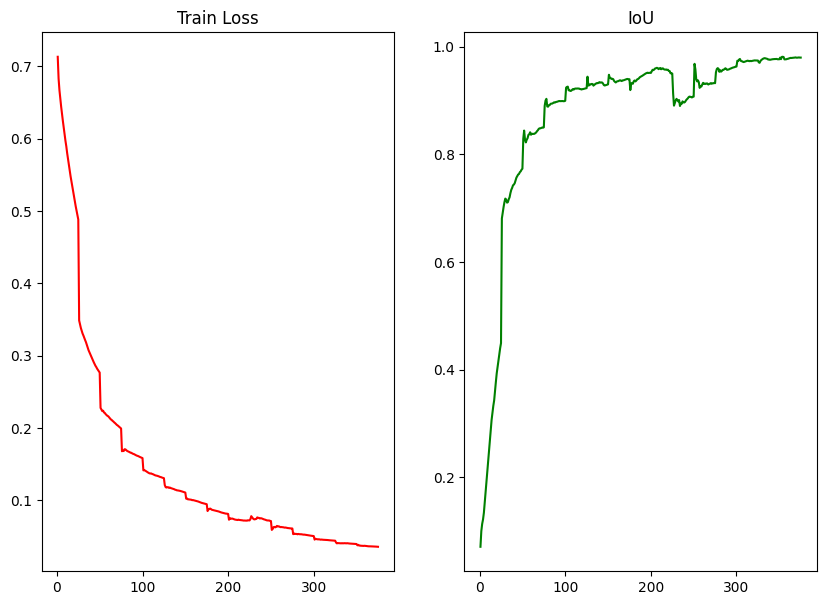

In [10]:
plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(losses)+1), losses, c='r')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(ious)+1), ious, c='g')
plt.title('IoU')

plt.show()

In [11]:
test_ds = GlitchDataset(
    images_dir='/kaggle/input/the-glitch-hunter/test/images',
    masks_dir=None,
    is_test=True,
    img_transform=transform,
    mask_transform=transform,
)

test_loader = DataLoader(test_ds, shuffle=False, batch_size=8)

In [37]:
model.eval()

masks = []

for X_batch in tqdm(test_loader, desc='Test DataLoader'):
    X_batch = X_batch.to(device)
    with torch.no_grad():
        output = model(X_batch).cpu()
        output = torch.sigmoid(output)
        preds = (output>0.5).type(torch.uint8) * 255
    masks.append(preds)

masks = torch.cat(masks)

masks.shape

Test DataLoader:   0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([200, 1, 512, 512])

In [38]:
os.makedirs('submission', exist_ok=True)

for i, mask in tqdm(enumerate(masks), total=len(masks), desc='Writing PNG'):
    write_png(mask, os.path.join('submission', f"img_{(i+1):03d}.png"))

shutil.make_archive('submission', 'zip', 'submission')

Writing PNG:   0%|          | 0/200 [00:00<?, ?it/s]

'/kaggle/working/submission.zip'